In [1]:
import albumentations as A
import torch
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2

from torch.utils.data import DataLoader
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.image import load_image
from torchlake.common.models import ResNetFeatureExtractor
from torchlake.image_classification.models.darknet53 import DarkNet53FeatureExtractor
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.object_detection.constants.schema import DetectorContext
from torchlake.common.datasets.voc import VOCDetectionFromCSV, VOCDetectionFromLMDB
from torchlake.common.utils.platform import get_num_workers
from torchlake.object_detection.utils.train import collate_fn
from torchlake.common.controller.trainer import DoNothingTrainer
from torchlake.common.controller.recorder import TrainRecorder

from torchlake.object_detection.models.yolov3 import YOLOV3Loss, YOLOV3, PriorBox, Decoder
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.object_detection.utils.plot import draw_pred

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt

# setting

In [3]:
artifact_path = Path('../../artifacts/yolov3')
artifact_path.mkdir(exist_ok=True)

In [4]:
data_path = Path("../../data/VOCdevkit")

In [5]:
anchors_path = artifact_path.joinpath("voc.anchors.416.txt").as_posix()

In [6]:
NUM_CLASS = len(VOC_CLASS_NAMES)
NUM_ANCHORS = [3, 3, 3]

In [7]:
BATCH_SIZE = 32

In [8]:
IMAGE_SIZE = 416

In [9]:
CONTEXT = DetectorContext(
    detector_name="yolov3",
    dataset="VOC",
    device="cuda:0",
    num_classes=NUM_CLASS,
    num_anchors=NUM_ANCHORS,
    grid_sizes=tuple(IMAGE_SIZE // scale for scale in (8, 16, 32)),
    anchors_path=anchors_path,
)

# data

In [10]:
transform = A.Compose(
    [
        A.ColorJitter(p=0.3),
        A.HorizontalFlip(),
        # A.ShiftScaleRotate(p=0.5, rotate_limit=0),
        A.RandomSizedBBoxSafeCrop(IMAGE_SIZE, IMAGE_SIZE, erosion_rate=0.1),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [11]:
train_dataset = VOCDetectionFromLMDB(
    data_path.joinpath("voc").as_posix(),
    transform=transform,
)

In [12]:
# train_dataset.env.close()

In [13]:
for x, y in train_dataset:
    print(x.shape, len(y))
    break

torch.Size([3, 416, 416]) 1


In [14]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [15]:
for x, y in train_loader:
    print(x.shape, len(y))
    break

torch.Size([32, 3, 416, 416]) 32


# model

If you don't have anchors yet, build one in debug section

In [16]:
backbone = ResNetFeatureExtractor("resnet50", "block", trainable=True)
backbone.fix_target_layers(["2_1", "3_1", "4_1"])

In [17]:
# backbone = DarkNet53FeatureExtractor("block", "../../artifacts/darknet53/darknet53_448.pth", trainable=True)
# backbone.fix_target_layers(["2_1", "3_1", "4_1"])

In [18]:
model = YOLOV3(
    backbone,
    CONTEXT,
    hidden_dim_8x=backbone.feature_dims[-3],
    hidden_dim_16x=backbone.feature_dims[-2],
    hidden_dim_32x=backbone.feature_dims[-1],
    enable_spp=False,
).to(CONTEXT.device)

In [19]:
torchinfo.summary(model)

Layer (type:depth-idx)                             Param #
YOLOV3                                             --
├─ResNetFeatureExtractor: 1-1                      --
│    └─ResNet: 2-1                                 --
│    │    └─Conv2d: 3-1                            9,408
│    │    └─BatchNorm2d: 3-2                       128
│    │    └─ReLU: 3-3                              --
│    │    └─MaxPool2d: 3-4                         --
│    │    └─Module: 3-5                            215,808
│    │    └─Module: 3-6                            1,219,584
│    │    └─Module: 3-7                            7,098,368
│    │    └─Module: 3-8                            14,964,736
│    │    └─AdaptiveAvgPool2d: 3-9                 --
│    └─ImageNetNormalization: 2-2                  --
├─ModuleList: 1-2                                  --
│    └─Sequential: 2-3                             --
│    │    └─Conv2dNormActivation: 3-10             2,099,200
│    │    └─Conv2dNormActivation: 3-11 

In [20]:
priorBox = PriorBox(CONTEXT)
anchors = priorBox.load_anchors()

# train

In [21]:
CLS_LOSS_TYPE = "sigmoid"
LOC_LOSS_TYPE = "diou"

In [22]:
EPOCH = 100

In [23]:
trainer = DoNothingTrainer(EPOCH, CONTEXT.device)

In [24]:
recorder = TrainRecorder(0, EPOCH, num_loss=5, loss_names=["total", "cls", "noobj", "obj", "coord"])
recorder.increment_data_size(len(train_dataset))

In [25]:
# underestimate the loss, since we drop last batch
recorder.data_size

16551

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = YOLOV3Loss(
    anchors,
    CONTEXT,
    lambda_obj = 5,
    iou_threshold=0.5,
    return_all_loss=True,
    cls_loss_type=CLS_LOSS_TYPE,
    loc_loss_type=LOC_LOSS_TYPE,
)

if LOC_LOSS_TYPE.endswith("iou"):
    criterion.lambda_coord = 1

In [27]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [28]:
scaler = torch.amp.GradScaler()

In [29]:
def validate_func(model):
    from torchlake.object_detection.models.yolov3.decode import Decoder
    from torchlake.object_detection.configs.schema import InferenceCfg
    from torchlake.object_detection.controller.predictor import Predictor
    from torchlake.object_detection.controller.evaluator import Evaluator
    
    decoder = Decoder(anchors.to("cpu"), CONTEXT, cls_loss_type="softmax")
    inferCfg = InferenceCfg(METHOD="torchvision", CONF_THRESH=0.3, NMS_THRESH=0.5)
    
    predictor = Predictor(CONTEXT)
    predictor.set_postprocess_cfg(decoder, inferCfg)
    
    test_transform = A.Compose(
        [
            A.Resize(IMAGE_SIZE, IMAGE_SIZE),
            A.Normalize(0, 1),
            ToTensorV2(),
        ]
    )
    
    test_dataset = VOCDetectionFromCSV(
        data_path,
        data_path.joinpath("voc_test.csv"),
        transform=test_transform,
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        # num_workers=get_num_workers(),
        collate_fn=collate_fn,
    )
    
    evaluator = Evaluator(CONTEXT)
    
    result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES, verbose=False)
    
    print("validation mAP:", result_table['all'])

In [30]:
manager = WeightManager(artifact_path.joinpath("{detector_name}.{backbone_name}.{epoch}.{cls_loss_type}.{loc_loss_type}.spp.{spp}.pth").as_posix())
optimizer_manager = WeightManager(artifact_path.joinpath("adam.{lr:.1e}.{decay:.1e}.{epoch}.{hash}.pth").as_posix())

In [31]:
def checkpoint_func(model: YOLOV3, optimizer: torch.optim.Optimizer):
    model_filename = manager.get_filename(
        detector_name=CONTEXT.detector_name,
        backbone_name=backbone.network_name,
        epoch=recorder.current_epoch,
        cls_loss_type=CLS_LOSS_TYPE,
        loc_loss_type=LOC_LOSS_TYPE,
        spp=model.enable_spp,
    )
    manager.save_weight(model.state_dict(), model_filename)
    
    param_group = optimizer.param_groups[0]
    optimizer_filename = optimizer_manager.get_filename(
        lr=param_group['lr'],
        decay=param_group['weight_decay'],
        epoch=recorder.current_epoch,
        hash=hash(model_filename),
    )
    optimizer_manager.save_weight(optimizer.state_dict(), optimizer_filename)

In [ ]:
training_loss = trainer.run(
    train_loader,
    model,
    optimizer,
    criterion,
    scheduler=scheduler,
    recorder=recorder,
    scaler=scaler,
    validate_func=validate_func,
    checkpoint_func=checkpoint_func,
)

Enable AMP: True
Training...


100%|██████████| 517/517 [07:37<00:00,  1.13it/s]


------------------------------------
Epoch 1
------------------------------------
total: 2.2123e+02 (0.00%)
cls: 2.0324e+00 (0.00%)
noobj: 2.0666e+02 (0.00%)
obj: 1.1801e+00 (0.00%)
coord: 6.6357e+00 (0.00%)


100%|██████████| 517/517 [07:06<00:00,  1.21it/s]


------------------------------------
Epoch 2
------------------------------------
total: 1.9342e+01 (-91.00%)
cls: 1.1514e+00 (-43.00%)
noobj: 9.7825e+00 (-95.00%)
obj: 6.9870e-01 (-41.00%)
coord: 4.9149e+00 (-26.00%)


100%|██████████| 517/517 [07:17<00:00,  1.18it/s]


------------------------------------
Epoch 3
------------------------------------
total: 1.3223e+01 (-32.00%)
cls: 1.0078e+00 (-12.00%)
noobj: 4.6665e+00 (-52.00%)
obj: 5.8689e-01 (-16.00%)
coord: 4.6146e+00 (-6.00%)


100%|██████████| 517/517 [10:33<00:00,  1.23s/it]


------------------------------------
Epoch 4
------------------------------------
total: 1.0123e+01 (-23.00%)
cls: 7.9720e-01 (-21.00%)
noobj: 2.5776e+00 (-45.00%)
obj: 4.8449e-01 (-17.00%)
coord: 4.3259e+00 (-6.00%)


100%|██████████| 517/517 [08:06<00:00,  1.06it/s]


------------------------------------
Epoch 5
------------------------------------
total: 8.7839e+00 (-13.00%)
cls: 6.3685e-01 (-20.00%)
noobj: 1.8998e+00 (-26.00%)
obj: 4.2399e-01 (-12.00%)
coord: 4.1273e+00 (-5.00%)


100%|██████████| 517/517 [07:05<00:00,  1.21it/s]


------------------------------------
Epoch 6
------------------------------------
total: 7.9312e+00 (-10.00%)
cls: 5.3819e-01 (-15.00%)
noobj: 1.5367e+00 (-19.00%)
obj: 3.7865e-01 (-11.00%)
coord: 3.9631e+00 (-4.00%)


100%|██████████| 517/517 [07:05<00:00,  1.22it/s]


------------------------------------
Epoch 7
------------------------------------
total: 7.4971e+00 (-5.00%)
cls: 4.8559e-01 (-10.00%)
noobj: 1.3159e+00 (-14.00%)
obj: 3.5424e-01 (-6.00%)
coord: 3.9244e+00 (-1.00%)


100%|██████████| 517/517 [10:08<00:00,  1.18s/it]


------------------------------------
Epoch 8
------------------------------------
total: 7.0965e+00 (-5.00%)
cls: 4.4269e-01 (-9.00%)
noobj: 1.1705e+00 (-11.00%)
obj: 3.2522e-01 (-8.00%)
coord: 3.8572e+00 (-2.00%)


100%|██████████| 517/517 [09:04<00:00,  1.05s/it]


------------------------------------
Epoch 9
------------------------------------
total: 6.6330e+00 (-7.00%)
cls: 4.1236e-01 (-7.00%)
noobj: 1.0040e+00 (-14.00%)
obj: 2.9993e-01 (-8.00%)
coord: 3.7169e+00 (-4.00%)


100%|██████████| 517/517 [07:07<00:00,  1.21it/s]


------------------------------------
Epoch 10
------------------------------------
total: 6.3561e+00 (-4.00%)
cls: 3.7739e-01 (-8.00%)
noobj: 9.0578e-01 (-10.00%)
obj: 2.7812e-01 (-7.00%)
coord: 3.6823e+00 (-1.00%)
Validating...


  0%|          | 0/155 [00:00<?, ?it/s]D:\research\pytorch-implementations\gits\torchlake\object_detection\mixins\decode_yolo.py:29: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  cls_indices_offset = torch.searchsorted(
100%|██████████| 155/155 [02:08<00:00,  1.21it/s]


validation mAP: AP@0.5    0.678136
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov3\yolov3.resnet50.10.sigmoid.diou.spp.False.pth, model size is 410.08MiB
Save weight to ..\..\artifacts\yolov3\adam.1.0e-04.1.0e-05.10.2582582847251741139.pth, model size is 819.36MiB


100%|██████████| 517/517 [07:07<00:00,  1.21it/s]


------------------------------------
Epoch 11
------------------------------------
total: 7.1211e+00 (12.00%)
cls: 5.0165e-01 (33.00%)
noobj: 9.8853e-01 (9.00%)
obj: 3.8302e-01 (38.00%)
coord: 3.7159e+00 (1.00%)


100%|██████████| 517/517 [08:39<00:00,  1.00s/it]


------------------------------------
Epoch 12
------------------------------------
total: 6.4023e+00 (-10.00%)
cls: 4.3074e-01 (-14.00%)
noobj: 8.4578e-01 (-14.00%)
obj: 3.1190e-01 (-19.00%)
coord: 3.5663e+00 (-4.00%)


100%|██████████| 517/517 [07:03<00:00,  1.22it/s]


------------------------------------
Epoch 13
------------------------------------
total: 5.0681e+00 (-21.00%)
cls: 2.8442e-01 (-34.00%)
noobj: 5.8309e-01 (-31.00%)
obj: 2.0667e-01 (-34.00%)
coord: 3.1673e+00 (-11.00%)


100%|██████████| 517/517 [07:03<00:00,  1.22it/s]


------------------------------------
Epoch 14
------------------------------------
total: 4.7141e+00 (-7.00%)
cls: 2.5173e-01 (-11.00%)
noobj: 5.2073e-01 (-11.00%)
obj: 1.8335e-01 (-11.00%)
coord: 3.0249e+00 (-4.00%)


100%|██████████| 517/517 [09:07<00:00,  1.06s/it]


------------------------------------
Epoch 15
------------------------------------
total: 4.5868e+00 (-3.00%)
cls: 2.3689e-01 (-6.00%)
noobj: 4.9001e-01 (-6.00%)
obj: 1.7161e-01 (-6.00%)
coord: 3.0019e+00 (-1.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 16
------------------------------------
total: 4.4975e+00 (-2.00%)
cls: 2.2738e-01 (-4.00%)
noobj: 4.7239e-01 (-4.00%)
obj: 1.6527e-01 (-4.00%)
coord: 2.9714e+00 (-1.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 17
------------------------------------
total: 4.3810e+00 (-3.00%)
cls: 2.1867e-01 (-4.00%)
noobj: 4.4996e-01 (-5.00%)
obj: 1.5653e-01 (-5.00%)
coord: 2.9298e+00 (-1.00%)


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 18
------------------------------------
total: 4.3306e+00 (-1.00%)
cls: 2.0970e-01 (-4.00%)
noobj: 4.3942e-01 (-2.00%)
obj: 1.5250e-01 (-3.00%)
coord: 2.9190e+00 (0.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 19
------------------------------------
total: 4.2523e+00 (-2.00%)
cls: 2.0120e-01 (-4.00%)
noobj: 4.2782e-01 (-3.00%)
obj: 1.4530e-01 (-5.00%)
coord: 2.8967e+00 (-1.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 20
------------------------------------
total: 4.1988e+00 (-1.00%)
cls: 1.9717e-01 (-2.00%)
noobj: 4.1675e-01 (-3.00%)
obj: 1.4204e-01 (-2.00%)
coord: 2.8747e+00 (-1.00%)
Validating...


100%|██████████| 155/155 [03:37<00:00,  1.40s/it]


validation mAP: AP@0.5    0.752938
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov3\yolov3.resnet50.20.sigmoid.diou.spp.False.pth, model size is 410.08MiB
Save weight to ..\..\artifacts\yolov3\adam.1.0e-06.1.0e-05.20.-5552769828311341006.pth, model size is 819.37MiB


100%|██████████| 517/517 [07:37<00:00,  1.13it/s]


------------------------------------
Epoch 21
------------------------------------
total: 4.0577e+00 (-3.00%)
cls: 1.8493e-01 (-6.00%)
noobj: 3.9230e-01 (-6.00%)
obj: 1.3149e-01 (-7.00%)
coord: 2.8230e+00 (-2.00%)


100%|██████████| 517/517 [07:04<00:00,  1.22it/s]


------------------------------------
Epoch 22
------------------------------------
total: 4.0456e+00 (0.00%)
cls: 1.8756e-01 (1.00%)
noobj: 3.8983e-01 (-1.00%)
obj: 1.2933e-01 (-2.00%)
coord: 2.8215e+00 (0.00%)


100%|██████████| 517/517 [07:03<00:00,  1.22it/s]


------------------------------------
Epoch 23
------------------------------------
total: 4.0246e+00 (-1.00%)
cls: 1.8453e-01 (-2.00%)
noobj: 3.8476e-01 (-1.00%)
obj: 1.2979e-01 (0.00%)
coord: 2.8063e+00 (-1.00%)


100%|██████████| 517/517 [10:20<00:00,  1.20s/it]


------------------------------------
Epoch 24
------------------------------------
total: 3.9948e+00 (-1.00%)
cls: 1.8263e-01 (-1.00%)
noobj: 3.8234e-01 (-1.00%)
obj: 1.2781e-01 (-2.00%)
coord: 2.7908e+00 (-1.00%)


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 25
------------------------------------
total: 3.9767e+00 (0.00%)
cls: 1.8047e-01 (-1.00%)
noobj: 3.8580e-01 (1.00%)
obj: 1.2709e-01 (-1.00%)
coord: 2.7750e+00 (-1.00%)


100%|██████████| 517/517 [10:29<00:00,  1.22s/it]


------------------------------------
Epoch 26
------------------------------------
total: 4.0007e+00 (1.00%)
cls: 1.8263e-01 (1.00%)
noobj: 3.8024e-01 (-1.00%)
obj: 1.2832e-01 (1.00%)
coord: 2.7962e+00 (1.00%)


100%|██████████| 517/517 [10:29<00:00,  1.22s/it]


------------------------------------
Epoch 27
------------------------------------
total: 3.9528e+00 (-1.00%)
cls: 1.8013e-01 (-1.00%)
noobj: 3.7382e-01 (-2.00%)
obj: 1.2536e-01 (-2.00%)
coord: 2.7721e+00 (-1.00%)


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 28
------------------------------------
total: 3.9857e+00 (1.00%)
cls: 1.8028e-01 (0.00%)
noobj: 3.7752e-01 (1.00%)
obj: 1.2850e-01 (3.00%)
coord: 2.7854e+00 (0.00%)


100%|██████████| 517/517 [10:28<00:00,  1.22s/it]


------------------------------------
Epoch 29
------------------------------------
total: 3.9712e+00 (0.00%)
cls: 1.8254e-01 (1.00%)
noobj: 3.7055e-01 (-2.00%)
obj: 1.2965e-01 (1.00%)
coord: 2.7698e+00 (-1.00%)


100%|██████████| 517/517 [10:26<00:00,  1.21s/it]


------------------------------------
Epoch 30
------------------------------------
total: 3.9867e+00 (0.00%)
cls: 1.8194e-01 (0.00%)
noobj: 3.7545e-01 (1.00%)
obj: 1.2770e-01 (-2.00%)
coord: 2.7908e+00 (1.00%)
Validating...


100%|██████████| 155/155 [03:38<00:00,  1.41s/it]


validation mAP: AP@0.5    0.759696
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov3\yolov3.resnet50.30.sigmoid.diou.spp.False.pth, model size is 410.08MiB
Save weight to ..\..\artifacts\yolov3\adam.1.0e-08.1.0e-05.30.-5863553228246416750.pth, model size is 819.37MiB


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 31
------------------------------------
total: 3.9777e+00 (0.00%)
cls: 1.8275e-01 (0.00%)
noobj: 3.7763e-01 (1.00%)
obj: 1.2982e-01 (2.00%)
coord: 2.7682e+00 (-1.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 32
------------------------------------
total: 3.9626e+00 (0.00%)
cls: 1.8307e-01 (0.00%)
noobj: 3.6671e-01 (-3.00%)
obj: 1.2834e-01 (-1.00%)
coord: 2.7711e+00 (0.00%)


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 33
------------------------------------
total: 3.9738e+00 (0.00%)
cls: 1.8194e-01 (-1.00%)
noobj: 3.7551e-01 (2.00%)
obj: 1.2599e-01 (-2.00%)
coord: 2.7864e+00 (1.00%)


100%|██████████| 517/517 [10:29<00:00,  1.22s/it]


------------------------------------
Epoch 34
------------------------------------
total: 3.9871e+00 (0.00%)
cls: 1.8070e-01 (-1.00%)
noobj: 3.8187e-01 (2.00%)
obj: 1.2529e-01 (-1.00%)
coord: 2.7980e+00 (0.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 35
------------------------------------
total: 3.9667e+00 (-1.00%)
cls: 1.8289e-01 (1.00%)
noobj: 3.7190e-01 (-3.00%)
obj: 1.2597e-01 (1.00%)
coord: 2.7821e+00 (-1.00%)


100%|██████████| 517/517 [10:27<00:00,  1.21s/it]


------------------------------------
Epoch 36
------------------------------------
total: 3.9883e+00 (1.00%)
cls: 1.8309e-01 (0.00%)
noobj: 3.7142e-01 (0.00%)
obj: 1.2833e-01 (2.00%)
coord: 2.7921e+00 (0.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 37
------------------------------------
total: 3.9794e+00 (0.00%)
cls: 1.8223e-01 (0.00%)
noobj: 3.7953e-01 (2.00%)
obj: 1.2743e-01 (-1.00%)
coord: 2.7804e+00 (0.00%)


100%|██████████| 517/517 [10:29<00:00,  1.22s/it]


------------------------------------
Epoch 38
------------------------------------
total: 3.9876e+00 (0.00%)
cls: 1.8257e-01 (0.00%)
noobj: 3.8065e-01 (0.00%)
obj: 1.2743e-01 (0.00%)
coord: 2.7872e+00 (0.00%)


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 39
------------------------------------
total: 3.9487e+00 (-1.00%)
cls: 1.7875e-01 (-2.00%)
noobj: 3.7577e-01 (-1.00%)
obj: 1.2506e-01 (-2.00%)
coord: 2.7689e+00 (-1.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 40
------------------------------------
total: 3.9840e+00 (1.00%)
cls: 1.8104e-01 (1.00%)
noobj: 3.7120e-01 (-1.00%)
obj: 1.2724e-01 (2.00%)
coord: 2.7955e+00 (1.00%)
Validating...


100%|██████████| 155/155 [03:36<00:00,  1.40s/it]


validation mAP: AP@0.5    0.759964
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov3\yolov3.resnet50.40.sigmoid.diou.spp.False.pth, model size is 410.08MiB
Save weight to ..\..\artifacts\yolov3\adam.1.0e-08.1.0e-05.40.8189835651008424602.pth, model size is 819.36MiB


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 41
------------------------------------
total: 3.9950e+00 (0.00%)
cls: 1.7754e-01 (-2.00%)
noobj: 3.7765e-01 (2.00%)
obj: 1.2901e-01 (1.00%)
coord: 2.7947e+00 (0.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 42
------------------------------------
total: 3.9602e+00 (-1.00%)
cls: 1.7815e-01 (0.00%)
noobj: 3.7146e-01 (-2.00%)
obj: 1.2732e-01 (-1.00%)
coord: 2.7740e+00 (-1.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 43
------------------------------------
total: 3.9957e+00 (1.00%)
cls: 1.8097e-01 (2.00%)
noobj: 3.7770e-01 (2.00%)
obj: 1.2818e-01 (1.00%)
coord: 2.7962e+00 (1.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 44
------------------------------------
total: 3.9609e+00 (-1.00%)
cls: 1.7986e-01 (-1.00%)
noobj: 3.7913e-01 (0.00%)
obj: 1.2719e-01 (-1.00%)
coord: 2.7660e+00 (-1.00%)


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 45
------------------------------------
total: 3.9616e+00 (0.00%)
cls: 1.7929e-01 (0.00%)
noobj: 3.7308e-01 (-2.00%)
obj: 1.2700e-01 (0.00%)
coord: 2.7742e+00 (0.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 46
------------------------------------
total: 3.9893e+00 (1.00%)
cls: 1.8266e-01 (2.00%)
noobj: 3.7819e-01 (1.00%)
obj: 1.2705e-01 (0.00%)
coord: 2.7932e+00 (1.00%)


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 47
------------------------------------
total: 3.9660e+00 (-1.00%)
cls: 1.8342e-01 (0.00%)
noobj: 3.7337e-01 (-1.00%)
obj: 1.2719e-01 (0.00%)
coord: 2.7733e+00 (-1.00%)


100%|██████████| 517/517 [10:30<00:00,  1.22s/it]


------------------------------------
Epoch 48
------------------------------------
total: 3.9711e+00 (0.00%)
cls: 1.8055e-01 (-2.00%)
noobj: 3.7580e-01 (1.00%)
obj: 1.2662e-01 (0.00%)
coord: 2.7816e+00 (0.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 49
------------------------------------
total: 3.9799e+00 (0.00%)
cls: 1.8227e-01 (1.00%)
noobj: 3.8112e-01 (1.00%)
obj: 1.2704e-01 (0.00%)
coord: 2.7813e+00 (0.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 50
------------------------------------
total: 3.9710e+00 (0.00%)
cls: 1.8116e-01 (-1.00%)
noobj: 3.7269e-01 (-2.00%)
obj: 1.2609e-01 (-1.00%)
coord: 2.7867e+00 (0.00%)
Validating...


100%|██████████| 155/155 [03:37<00:00,  1.40s/it]


validation mAP: AP@0.5    0.759996
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov3\yolov3.resnet50.50.sigmoid.diou.spp.False.pth, model size is 410.08MiB
Save weight to ..\..\artifacts\yolov3\adam.1.0e-08.1.0e-05.50.2405023227936415892.pth, model size is 819.36MiB


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 51
------------------------------------
total: 3.9634e+00 (0.00%)
cls: 1.8058e-01 (0.00%)
noobj: 3.7451e-01 (0.00%)
obj: 1.2589e-01 (0.00%)
coord: 2.7789e+00 (0.00%)


100%|██████████| 517/517 [10:11<00:00,  1.18s/it]


------------------------------------
Epoch 52
------------------------------------
total: 3.9867e+00 (1.00%)
cls: 1.8022e-01 (0.00%)
noobj: 3.7431e-01 (0.00%)
obj: 1.2663e-01 (1.00%)
coord: 2.7990e+00 (1.00%)


100%|██████████| 517/517 [10:00<00:00,  1.16s/it]


------------------------------------
Epoch 53
------------------------------------
total: 3.9657e+00 (-1.00%)
cls: 1.7990e-01 (0.00%)
noobj: 3.7505e-01 (0.00%)
obj: 1.2579e-01 (-1.00%)
coord: 2.7818e+00 (-1.00%)


100%|██████████| 517/517 [10:50<00:00,  1.26s/it]


------------------------------------
Epoch 54
------------------------------------
total: 3.9572e+00 (0.00%)
cls: 1.8259e-01 (1.00%)
noobj: 3.7813e-01 (1.00%)
obj: 1.2660e-01 (1.00%)
coord: 2.7635e+00 (-1.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 55
------------------------------------
total: 3.9611e+00 (0.00%)
cls: 1.8008e-01 (-1.00%)
noobj: 3.7575e-01 (-1.00%)
obj: 1.2514e-01 (-1.00%)
coord: 2.7796e+00 (1.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 56
------------------------------------
total: 3.9516e+00 (0.00%)
cls: 1.7991e-01 (0.00%)
noobj: 3.7944e-01 (1.00%)
obj: 1.2571e-01 (0.00%)
coord: 2.7637e+00 (-1.00%)


100%|██████████| 517/517 [10:33<00:00,  1.22s/it]


------------------------------------
Epoch 57
------------------------------------
total: 3.9790e+00 (1.00%)
cls: 1.8259e-01 (1.00%)
noobj: 3.7271e-01 (-2.00%)
obj: 1.2728e-01 (1.00%)
coord: 2.7873e+00 (1.00%)


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 58
------------------------------------
total: 3.9618e+00 (0.00%)
cls: 1.8111e-01 (-1.00%)
noobj: 3.7607e-01 (1.00%)
obj: 1.2643e-01 (-1.00%)
coord: 2.7725e+00 (-1.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 59
------------------------------------
total: 3.9732e+00 (0.00%)
cls: 1.8089e-01 (0.00%)
noobj: 3.7321e-01 (-1.00%)
obj: 1.2533e-01 (-1.00%)
coord: 2.7924e+00 (1.00%)


100%|██████████| 517/517 [10:33<00:00,  1.22s/it]


------------------------------------
Epoch 60
------------------------------------
total: 3.9732e+00 (0.00%)
cls: 1.8031e-01 (0.00%)
noobj: 3.7766e-01 (1.00%)
obj: 1.2913e-01 (3.00%)
coord: 2.7696e+00 (-1.00%)
Validating...


100%|██████████| 155/155 [03:36<00:00,  1.40s/it]


validation mAP: AP@0.5    0.760555
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov3\yolov3.resnet50.60.sigmoid.diou.spp.False.pth, model size is 410.08MiB
Save weight to ..\..\artifacts\yolov3\adam.1.0e-08.1.0e-05.60.3547359979364988524.pth, model size is 819.36MiB


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 61
------------------------------------
total: 3.9698e+00 (0.00%)
cls: 1.8088e-01 (0.00%)
noobj: 3.7866e-01 (0.00%)
obj: 1.2613e-01 (-2.00%)
coord: 2.7796e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.22s/it]


------------------------------------
Epoch 62
------------------------------------
total: 3.9619e+00 (0.00%)
cls: 1.8055e-01 (0.00%)
noobj: 3.7731e-01 (0.00%)
obj: 1.2630e-01 (0.00%)
coord: 2.7726e+00 (0.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 63
------------------------------------
total: 3.9784e+00 (0.00%)
cls: 1.8001e-01 (0.00%)
noobj: 3.7158e-01 (-2.00%)
obj: 1.2830e-01 (2.00%)
coord: 2.7853e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.22s/it]


------------------------------------
Epoch 64
------------------------------------
total: 3.9880e+00 (0.00%)
cls: 1.8131e-01 (1.00%)
noobj: 3.7747e-01 (2.00%)
obj: 1.2809e-01 (0.00%)
coord: 2.7887e+00 (0.00%)


100%|██████████| 517/517 [10:31<00:00,  1.22s/it]


------------------------------------
Epoch 65
------------------------------------
total: 3.9520e+00 (-1.00%)
cls: 1.8139e-01 (0.00%)
noobj: 3.7085e-01 (-2.00%)
obj: 1.2604e-01 (-2.00%)
coord: 2.7696e+00 (-1.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 66
------------------------------------
total: 3.9592e+00 (0.00%)
cls: 1.8002e-01 (-1.00%)
noobj: 3.7476e-01 (1.00%)
obj: 1.2652e-01 (0.00%)
coord: 2.7718e+00 (0.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 67
------------------------------------
total: 3.9551e+00 (0.00%)
cls: 1.7974e-01 (0.00%)
noobj: 3.7737e-01 (1.00%)
obj: 1.2583e-01 (-1.00%)
coord: 2.7688e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.23s/it]


------------------------------------
Epoch 68
------------------------------------
total: 3.9691e+00 (0.00%)
cls: 1.8049e-01 (0.00%)
noobj: 3.7070e-01 (-2.00%)
obj: 1.2726e-01 (1.00%)
coord: 2.7816e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.23s/it]


------------------------------------
Epoch 69
------------------------------------
total: 3.9548e+00 (0.00%)
cls: 1.8070e-01 (0.00%)
noobj: 3.7575e-01 (1.00%)
obj: 1.2641e-01 (-1.00%)
coord: 2.7663e+00 (-1.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 70
------------------------------------
total: 3.9779e+00 (1.00%)
cls: 1.8385e-01 (2.00%)
noobj: 3.7694e-01 (0.00%)
obj: 1.2910e-01 (2.00%)
coord: 2.7716e+00 (0.00%)
Validating...


100%|██████████| 155/155 [04:09<00:00,  1.61s/it]


validation mAP: AP@0.5    0.760388
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov3\yolov3.resnet50.70.sigmoid.diou.spp.False.pth, model size is 410.08MiB
Save weight to ..\..\artifacts\yolov3\adam.1.0e-08.1.0e-05.70.-5085654910736261614.pth, model size is 819.37MiB


100%|██████████| 517/517 [10:33<00:00,  1.23s/it]


------------------------------------
Epoch 71
------------------------------------
total: 3.9596e+00 (0.00%)
cls: 1.8401e-01 (0.00%)
noobj: 3.7404e-01 (-1.00%)
obj: 1.2582e-01 (-3.00%)
coord: 2.7725e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.23s/it]


------------------------------------
Epoch 72
------------------------------------
total: 3.9533e+00 (0.00%)
cls: 1.8252e-01 (-1.00%)
noobj: 3.7034e-01 (-1.00%)
obj: 1.2446e-01 (-1.00%)
coord: 2.7782e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.22s/it]


------------------------------------
Epoch 73
------------------------------------
total: 3.9487e+00 (0.00%)
cls: 1.8028e-01 (-1.00%)
noobj: 3.7011e-01 (0.00%)
obj: 1.2753e-01 (2.00%)
coord: 2.7606e+00 (-1.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 74
------------------------------------
total: 3.9451e+00 (0.00%)
cls: 1.8373e-01 (2.00%)
noobj: 3.7308e-01 (1.00%)
obj: 1.2554e-01 (-2.00%)
coord: 2.7606e+00 (0.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 75
------------------------------------
total: 3.9514e+00 (0.00%)
cls: 1.7924e-01 (-2.00%)
noobj: 3.7205e-01 (0.00%)
obj: 1.2635e-01 (1.00%)
coord: 2.7683e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.22s/it]


------------------------------------
Epoch 76
------------------------------------
total: 3.9663e+00 (0.00%)
cls: 1.8090e-01 (1.00%)
noobj: 3.6827e-01 (-1.00%)
obj: 1.2686e-01 (0.00%)
coord: 2.7828e+00 (1.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 77
------------------------------------
total: 3.9783e+00 (0.00%)
cls: 1.8089e-01 (0.00%)
noobj: 3.7384e-01 (2.00%)
obj: 1.2904e-01 (2.00%)
coord: 2.7783e+00 (0.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 78
------------------------------------
total: 3.9550e+00 (-1.00%)
cls: 1.7996e-01 (-1.00%)
noobj: 3.7128e-01 (-1.00%)
obj: 1.2667e-01 (-2.00%)
coord: 2.7705e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.22s/it]


------------------------------------
Epoch 79
------------------------------------
total: 3.9476e+00 (0.00%)
cls: 1.7868e-01 (-1.00%)
noobj: 3.7310e-01 (0.00%)
obj: 1.2538e-01 (-1.00%)
coord: 2.7689e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.23s/it]


------------------------------------
Epoch 80
------------------------------------
total: 3.9739e+00 (1.00%)
cls: 1.8100e-01 (1.00%)
noobj: 3.8487e-01 (3.00%)
obj: 1.2495e-01 (0.00%)
coord: 2.7833e+00 (1.00%)
Validating...


100%|██████████| 155/155 [04:14<00:00,  1.64s/it]


validation mAP: AP@0.5    0.760654
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov3\yolov3.resnet50.80.sigmoid.diou.spp.False.pth, model size is 410.08MiB
Save weight to ..\..\artifacts\yolov3\adam.1.0e-08.1.0e-05.80.26060699338596173.pth, model size is 819.36MiB


100%|██████████| 517/517 [10:36<00:00,  1.23s/it]


------------------------------------
Epoch 81
------------------------------------
total: 3.9610e+00 (0.00%)
cls: 1.8116e-01 (0.00%)
noobj: 3.7742e-01 (-2.00%)
obj: 1.2505e-01 (0.00%)
coord: 2.7772e+00 (0.00%)


100%|██████████| 517/517 [10:33<00:00,  1.23s/it]


------------------------------------
Epoch 82
------------------------------------
total: 3.9661e+00 (0.00%)
cls: 1.8160e-01 (0.00%)
noobj: 3.7931e-01 (1.00%)
obj: 1.2649e-01 (1.00%)
coord: 2.7727e+00 (0.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 83
------------------------------------
total: 3.9564e+00 (0.00%)
cls: 1.8087e-01 (0.00%)
noobj: 3.7510e-01 (-1.00%)
obj: 1.2382e-01 (-2.00%)
coord: 2.7814e+00 (0.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 84
------------------------------------
total: 3.9495e+00 (0.00%)
cls: 1.7987e-01 (-1.00%)
noobj: 3.7671e-01 (0.00%)
obj: 1.2600e-01 (2.00%)
coord: 2.7630e+00 (-1.00%)


100%|██████████| 517/517 [10:36<00:00,  1.23s/it]


------------------------------------
Epoch 85
------------------------------------
total: 3.9676e+00 (0.00%)
cls: 1.8134e-01 (1.00%)
noobj: 3.7557e-01 (0.00%)
obj: 1.2415e-01 (-1.00%)
coord: 2.7900e+00 (1.00%)


100%|██████████| 517/517 [10:32<00:00,  1.22s/it]


------------------------------------
Epoch 86
------------------------------------
total: 3.9631e+00 (0.00%)
cls: 1.7770e-01 (-2.00%)
noobj: 3.6921e-01 (-2.00%)
obj: 1.2863e-01 (4.00%)
coord: 2.7731e+00 (-1.00%)


100%|██████████| 517/517 [10:35<00:00,  1.23s/it]


------------------------------------
Epoch 87
------------------------------------
total: 3.9653e+00 (0.00%)
cls: 1.8180e-01 (2.00%)
noobj: 3.7936e-01 (3.00%)
obj: 1.2505e-01 (-3.00%)
coord: 2.7789e+00 (0.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 88
------------------------------------
total: 3.9802e+00 (0.00%)
cls: 1.8028e-01 (-1.00%)
noobj: 3.7553e-01 (-1.00%)
obj: 1.2818e-01 (3.00%)
coord: 2.7835e+00 (0.00%)


100%|██████████| 517/517 [10:35<00:00,  1.23s/it]


------------------------------------
Epoch 89
------------------------------------
total: 3.9553e+00 (-1.00%)
cls: 1.8173e-01 (1.00%)
noobj: 3.6800e-01 (-2.00%)
obj: 1.2766e-01 (0.00%)
coord: 2.7673e+00 (-1.00%)


100%|██████████| 517/517 [10:37<00:00,  1.23s/it]


------------------------------------
Epoch 90
------------------------------------
total: 3.9652e+00 (0.00%)
cls: 1.8130e-01 (0.00%)
noobj: 3.7247e-01 (1.00%)
obj: 1.2718e-01 (0.00%)
coord: 2.7755e+00 (0.00%)
Validating...


100%|██████████| 155/155 [03:45<00:00,  1.45s/it]


validation mAP: AP@0.5    0.760452
Name: all, dtype: float64
Checkpoint...
Save weight to ..\..\artifacts\yolov3\yolov3.resnet50.90.sigmoid.diou.spp.False.pth, model size is 410.08MiB
Save weight to ..\..\artifacts\yolov3\adam.1.0e-08.1.0e-05.90.5573252946205315211.pth, model size is 819.36MiB


100%|██████████| 517/517 [10:35<00:00,  1.23s/it]


------------------------------------
Epoch 91
------------------------------------
total: 3.9596e+00 (0.00%)
cls: 1.7833e-01 (-2.00%)
noobj: 3.7883e-01 (2.00%)
obj: 1.2517e-01 (-2.00%)
coord: 2.7766e+00 (0.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 92
------------------------------------
total: 3.9800e+00 (1.00%)
cls: 1.8150e-01 (2.00%)
noobj: 3.7830e-01 (0.00%)
obj: 1.2656e-01 (1.00%)
coord: 2.7874e+00 (0.00%)


100%|██████████| 517/517 [10:35<00:00,  1.23s/it]


------------------------------------
Epoch 93
------------------------------------
total: 3.9820e+00 (0.00%)
cls: 1.7947e-01 (-1.00%)
noobj: 3.7212e-01 (-2.00%)
obj: 1.2678e-01 (0.00%)
coord: 2.7965e+00 (0.00%)


100%|██████████| 517/517 [10:34<00:00,  1.23s/it]


------------------------------------
Epoch 94
------------------------------------
total: 3.9629e+00 (0.00%)
cls: 1.7973e-01 (0.00%)
noobj: 3.7184e-01 (0.00%)
obj: 1.2566e-01 (-1.00%)
coord: 2.7830e+00 (0.00%)


100%|██████████| 517/517 [10:35<00:00,  1.23s/it]


------------------------------------
Epoch 95
------------------------------------
total: 3.9878e+00 (1.00%)
cls: 1.7891e-01 (0.00%)
noobj: 3.7500e-01 (1.00%)
obj: 1.2849e-01 (2.00%)
coord: 2.7914e+00 (0.00%)


  3%|▎         | 14/517 [00:17<10:25,  1.24s/it]

In [ ]:
train_dataset.env.close()

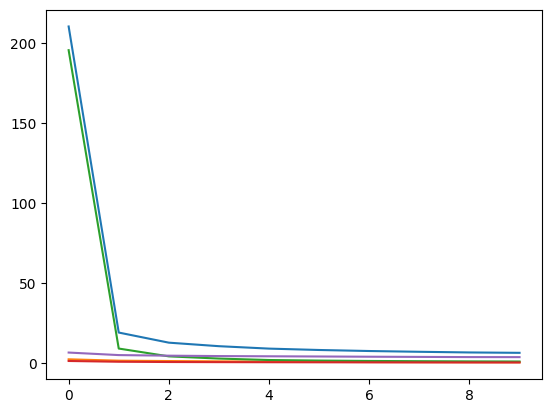

In [ ]:
plt.plot(torch.Tensor(recorder.training_losses).T)

# load

In [22]:
from torchlake.common.controller.weight_manager import WeightManager

In [23]:
manager = WeightManager(artifact_path.joinpath("{detector_name}.{backbone_name}.{epoch}.{cls_loss_type}.{loc_loss_type}.spp.{spp}.pth").as_posix())

In [24]:
model_path = manager.get_filename(
    detector_name=CONTEXT.detector_name,
    backbone_name=backbone.network_name,
    epoch=60,
    cls_loss_type=CLS_LOSS_TYPE,
    loc_loss_type=LOC_LOSS_TYPE,
    spp=model.enable_spp,
)

In [25]:
model_path

WindowsPath('../../artifacts/yolov3/yolov3.resnet50.60.sigmoid.diou.spp.False.pth')

In [26]:
manager.load_weight(model_path, model)

# Inference

In [37]:
from tqdm import tqdm
from torchlake.object_detection.models.yolov3.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg, PostProcessParameter
from torchlake.object_detection.controller.predictor import Predictor

In [51]:
decoder = Decoder(anchors.to("cpu"), CONTEXT, cls_loss_type="softmax")
inferCfg = InferenceCfg(
    METHOD="torchvision",
    # METHOD="diou",
    CONF_THRESH=0.5,
    NMS_THRESH=0.5,
    # PARAMETER=PostProcessParameter(BETA=1),
)

In [52]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [53]:
test_transform = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    # bbox_params=A.BboxParams(
    #     format="yolo",
    #     # min_area=1024,
    #     # min_visibility=0.3,
    # ),
)

In [54]:
import numpy as np
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import rand_color_map, plot_grids

In [55]:
color_map = rand_color_map(VOC_CLASS_NAMES)

In [43]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [44]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [45]:
model.eval()
with torch.no_grad():
    for img, labels in tqdm(test_loader):
        img = img.to(CONTEXT.device)

        # B x (?, 25)
        output = predictor.detect_image(model, img, is_batch=True)
        break

  0%|          | 0/154 [00:01<?, ?it/s]


In [70]:
# model.eval()
# with torch.no_grad():
#     output = model(img)
#     decoded = decoder.decode(output.cpu(), (224, 224))
#     boxes = decoded[0]
#     # boxes = output[0].unflatten(0, (5, 25)).permute(0, 2, 3, 1).reshape(-1, 25)
#     print(boxes[boxes[:, 4] > 0.1])

In [46]:
placeholder = []
for im, o in zip(img, output):
    overlay = img_tensor_to_np(im, 255, np.uint8)
    draw_pred(
        overlay,
        o,
        class_names=VOC_CLASS_NAMES,
        class_colors=color_map,
    )
    placeholder.append(overlay)

chair: 0.67
chair: 0.62
chair: 0.40
chair: 0.99
diningtable: 0.75
dog: 1.00
person: 0.97
person: 0.41
person: 0.66
person: 0.97
pottedplant: 0.97
bird: 0.98
person: 0.61
person: 0.85
person: 0.98
person: 0.97
person: 0.99
person: 0.34
person: 0.46
person: 1.00
person: 1.00
person: 0.60
person: 0.98
tvmonitor: 0.43
bicycle: 0.48
motorbike: 0.48
person: 0.99
person: 0.98
person: 0.98
person: 0.93
person: 0.99
person: 1.00
bicycle: 0.99
bottle: 0.73
person: 1.00
tvmonitor: 0.97
tvmonitor: 0.98
bicycle: 1.00
bicycle: 1.00
person: 1.00
person: 1.00
person: 0.58
person: 0.89
cat: 0.94
dog: 0.99
motorbike: 0.38
motorbike: 0.89
motorbike: 0.98
motorbike: 0.98
motorbike: 0.97
person: 0.41
boat: 0.88
boat: 0.47
person: 0.96
person: 0.99
dog: 0.90
person: 1.00
aeroplane: 1.00
person: 0.79
person: 0.99
person: 0.88
person: 0.98
person: 0.99
person: 0.57
person: 0.54
train: 1.00
train: 1.00
train: 0.38
person: 1.00
person: 1.00
person: 1.00
bottle: 1.00
diningtable: 0.83
person: 1.00
person: 0.99
p

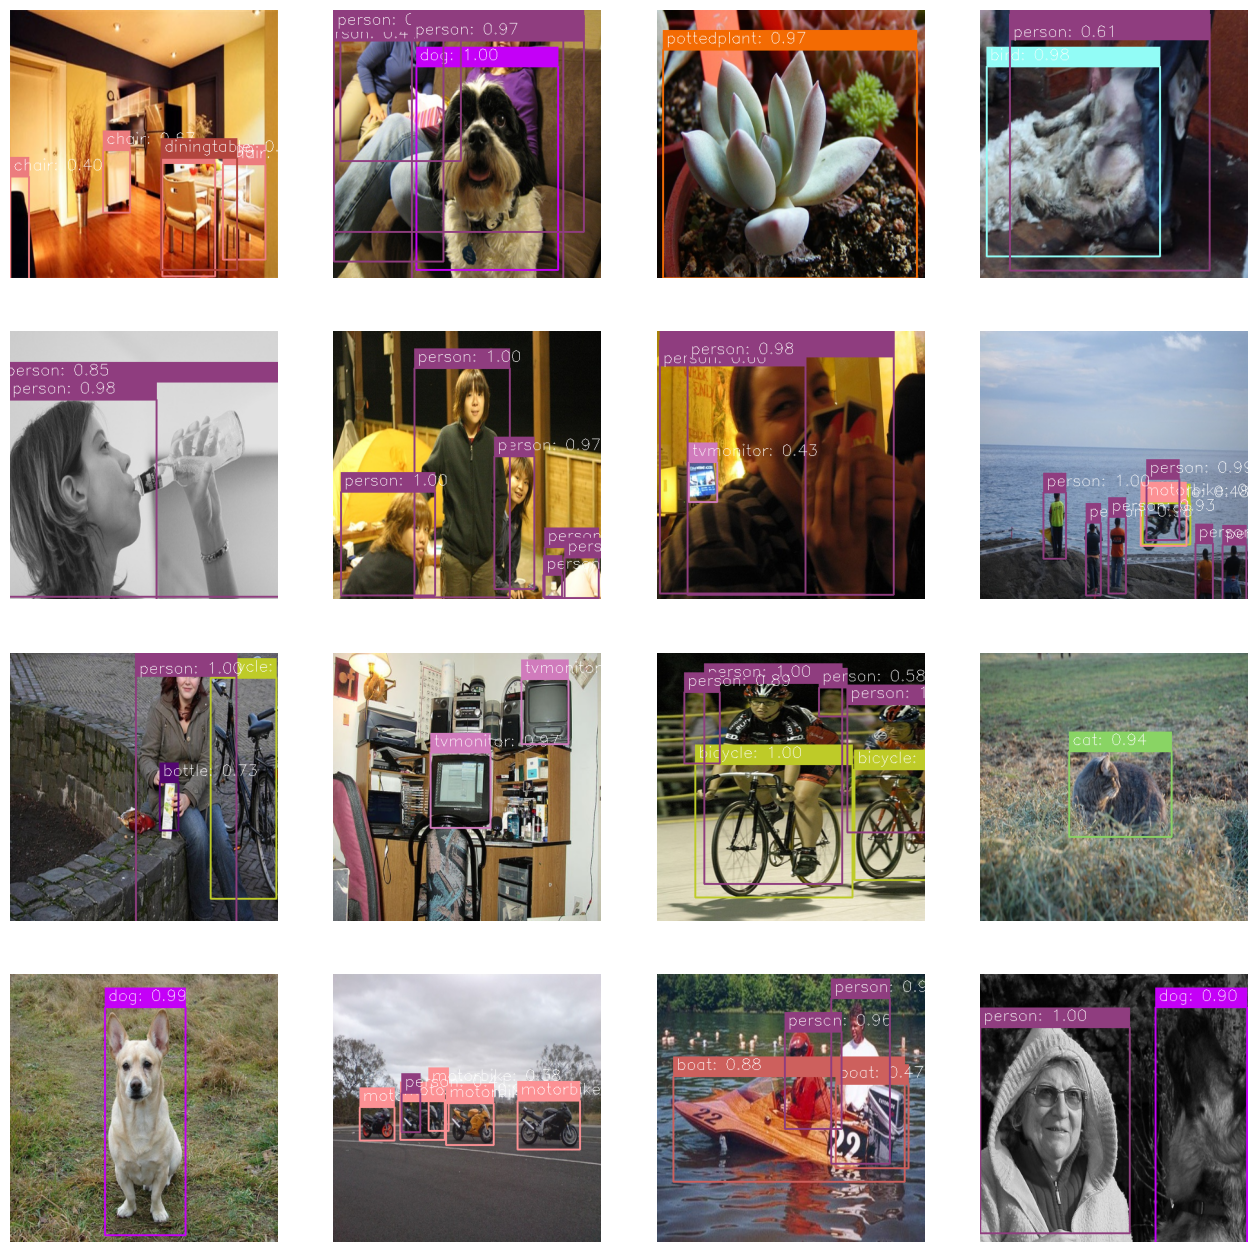

In [47]:
plot_grids(
    placeholder[:16],
    num_row=4,
    num_col=4,
    figsize=(16,16),
)

In [57]:
humans_img = "D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg"
human_img = "D://W/hmm/Screenshot_20240612_091521.jpg"
obj_img = "D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg"

predictor.predict_image_file(
    model,
    [humans_img, human_img, obj_img],
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
)

person: 1.00
person: 0.99
D://research/pytorch-implementations/data/coco/train2017/000000000165.jpg 2
person: 1.00
D://W/hmm/Screenshot_20240612_091521.jpg 1
aeroplane: 0.96
aeroplane: 0.90
aeroplane: 0.99
D://research/pytorch-implementations/data/VOCdevkit/VOC2012/JPEGImages/2007_000033.jpg 3


In [56]:
predictor.predict_video_file(
    model,
    "../../data/movie.mp4",
    VOC_CLASS_NAMES,
    color_map,
    test_transform,
    show=False,
    save_dir=artifact_path.as_posix(),
    verbose=False,
)

Video end


# evaluate

In [27]:
from torchlake.object_detection.models.yolov3.decode import Decoder
from torchlake.object_detection.configs.schema import InferenceCfg, PostProcessParameter
from torchlake.object_detection.controller.predictor import Predictor
from torchlake.object_detection.controller.evaluator import Evaluator

In [28]:
VAL_IMAGE_SIZE = 416

In [29]:
decoder = Decoder(anchors.to("cpu"), CONTEXT, cls_loss_type="softmax")
inferCfg = InferenceCfg(
    METHOD="torchvision",
    # METHOD="diou",
    CONF_THRESH=0.3,
    NMS_THRESH=0.5,
    # PARAMETER=PostProcessParameter(BETA=1),
)

In [30]:
predictor = Predictor(CONTEXT)
predictor.set_postprocess_cfg(decoder, inferCfg)

In [31]:
test_transform = A.Compose(
    [
        A.Resize(VAL_IMAGE_SIZE, VAL_IMAGE_SIZE),
        A.Normalize(0, 1),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(
        format="yolo",
        # min_area=1024,
        # min_visibility=0.3,
    ),
)

In [32]:
test_dataset = VOCDetectionFromCSV(
    data_path,
    data_path.joinpath("voc_test.csv"),
    transform=test_transform,
)

In [33]:
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    # shuffle=True,
    pin_memory=True,
    # num_workers=get_num_workers(),
    collate_fn=collate_fn,
)

In [34]:
evaluator = Evaluator(CONTEXT)

In [35]:
result_table = evaluator.run(predictor, model, test_loader, VOC_CLASS_NAMES)

100%|██████████| 155/155 [03:51<00:00,  1.50s/it]


       aeroplane   bicycle      bird      boat    bottle      bus      car  \
AP@0.5  0.708094  0.781522  0.785989  0.765821  0.686077  0.69268  0.76812   

            cat     chair      cow  ...       dog     horse motorbike  \
AP@0.5  0.77851  0.755429  0.75589  ...  0.774364  0.779378  0.781727   

          person pottedplant     sheep      sofa     train tvmonitor       all  
AP@0.5  0.777593    0.770912  0.770641  0.770025  0.771388  0.771819  0.760517  

[1 rows x 21 columns]


In [36]:
result_table.T

,AP@0.5
aeroplane,0.708094
bicycle,0.781522
bird,0.785989
boat,0.765821
bottle,0.686077
bus,0.69268
car,0.76812
cat,0.77851
chair,0.755429
cow,0.75589


# further evaluation